In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.96MB/s]


Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


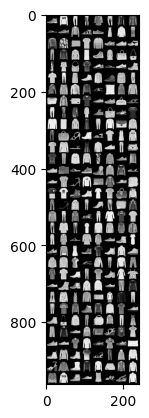

In [2]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(test_loader)
images, labels = next(data_iter)
# Show images
show(torchvision.utils.make_grid(images))

This is the Fashion MNIST dataset. In this dataset, there are 48, 000 images in the training set, 12, 000 images in the validation set, and 10, 000 images in the test set. Each image is of size 1 × 28 × 28. Each image is assigned to one of the following 10 labels: {T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle Boot}

In [3]:
# Build and design convolutional neural network
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        # determine which layers will be used in the network model here
        super().__init__()
        self.l1 = nn.Conv2d(1, 28, 4, stride=2, padding=1)
        self.l2 = nn.Conv2d(28, 28, 5, stride=3, padding=2)
        self.l3 = nn.Conv2d(28, 28, 1, stride=2)
        self.maxpool = nn.MaxPool2d(2, stride=3)
        self.flat = nn.Flatten()
        self.l4 = nn.Linear(28, 50)
        self.l5 = nn.Linear(50, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # input is data samples and the output is the model prediction
        x = self.l1(x)
        x = self.maxpool(x)
        x = self.l2(x)
        x = self.maxpool(x)
        x = self.l3(self.relu(x))
        x = self.flat(x)
        x = self.l4(x)
        return self.relu(self.l5(x))

In [4]:
# Run a complete training epoch of forward and backward pass to update the model.
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # initialize the model and determine which loss function and which optimizer to use
    # keep track of the loss and accuracy of the model on both the training and test sets after every training epoch
    # output of this method includes the train loss and train accuracy of the model after the model update
    features, labels = next(iter(train_loader))
    model.train()
    y_logits = model(features)
    y_hat = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    #loss
    l_2 = torch.sqrt(torch.pow(features, 2).sum()).item()
    loss = loss_fn(y_logits, labels) + reg_param * l_2
    # accuracy
    acc = torch.eq(y_hat, labels).sum().item() / len(y_hat)

    # Update step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss, acc

In [5]:
# Evaluate model on the test or validation set
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # output is the loss and accuracy of the model on the test set
    features, labels = next(iter(data_loader))
    model.eval()
    y_logits = model(features)
    y_hat = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    #loss
    l_2 = torch.sqrt(torch.pow(features, 2).sum())
    loss = loss_fn(y_logits, labels) + reg_param * l_2
    # accuracy
    acc = torch.eq(y_hat, labels).sum().item() / len(y_hat)

    return loss, acc

In [6]:
# Train model using the methods train step and evaluation step implemented
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # initialize the model and determine which loss function and which optimizer to use
    # tune the hyper-parameters including the model architecture, the learning rate, and the regularization parameter, etc
    # based on the performance of the model on the validation set during the training process

    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # Train the model here

    input_size = 784 # 28 * 28
    output_size = 10
    reg_param = 0.01
    model = ConvModel(input_size, output_size).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

    train_l_holder = []
    train_a_holder = []
    valid_l_holder = []
    valid_a_holder = []
    test_l_holder = []
    test_a_holder = []

    for epoch in range(2000):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        train_l_holder.append(train_loss.item())
        train_a_holder.append(train_acc)
        valid_l_holder.append(valid_loss.item())
        valid_a_holder.append(valid_acc)
        test_l_holder.append(test_loss.item())
        test_a_holder.append(test_acc)

    return model, train_l_holder, train_a_holder, valid_l_holder, valid_a_holder, test_l_holder, test_a_holder


In [7]:
# Intialize and train the model
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Train : 0.9375 Valid: 0.9375 Test: 0.91796875


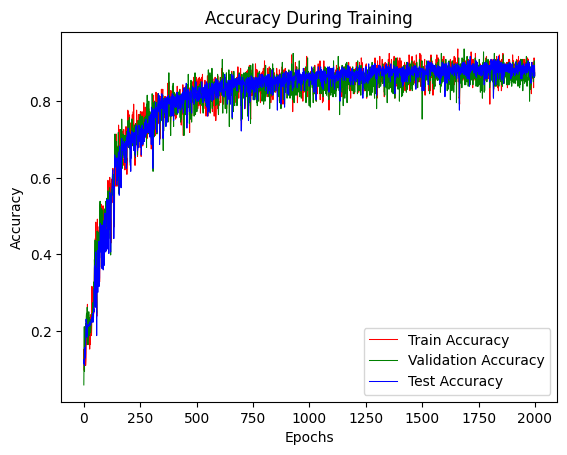

In [8]:
# plot accuracy curves
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    print("Train :", max(train_accuracies), "Valid:", max(valid_accuracies), "Test:", max(test_accuracies))
    plt.plot(train_accuracies, c='r', linewidth=0.75)
    plt.plot(valid_accuracies, c='g', linewidth=0.75)
    plt.plot(test_accuracies, c='b', linewidth=0.75)
    plt.legend(["Train Accuracy","Validation Accuracy", "Test Accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Accuracy During Training")

plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

Train : 2.1660680770874023 Valid: 2.230849266052246 Test: 2.35319185256958


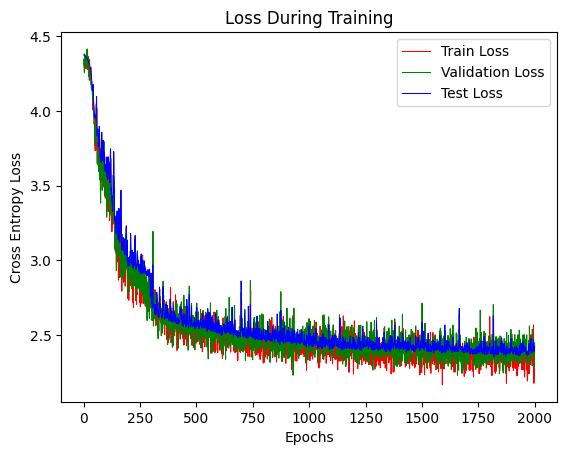

In [9]:
# plot loss curves
def plot_loss_performance(train_losses, valid_losses, test_losses):
    print("Train :", min(train_losses), "Valid:", min(valid_losses), "Test:", min(test_losses))
    plt.plot(train_losses, c='r', linewidth=0.75)
    plt.plot(valid_losses, c='g', linewidth=0.75)
    plt.plot(test_losses, c='b', linewidth=0.75)
    plt.legend(["Train Loss","Validation Loss", "Test Loss"])
    plt.ylabel("Cross Entropy Loss")
    plt.xlabel("Epochs")
    plt.title("Loss During Training")

plot_loss_performance(train_losses, valid_losses, test_losses)